# ml-1m

In [5]:
# Apply fairness-aware data re-sampling (inspired by Ekstrand et al.) on ml-1m dataset for RecBole
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# 1. Load user profile, label interactions and original atomic interactions
user_df = pd.read_csv('../datasets/atomic_datasets/ml-1m/ml-1m.user', sep='\t')  # user_id:token, gender, age, etc.
inter_df_label = pd.read_csv('../datasets/split_datasets/ml-1m/ml-1m.train.inter', sep='\t')  # user_id:token, item_id:token, timestamp, label
inter_df_atomic = pd.read_csv('../datasets/atomic_datasets/ml-1m/ml-1m.inter', sep='\t')  # user_id:token, item_id:token, rating, timestamp

# 2. Merge rating into train.inter
inter_df = inter_df_label.merge(
    inter_df_atomic[['user_id:token', 'item_id:token', 'rating:float']],
    how='left',
    left_on=['user_id:token', 'item_id:token'],
    right_on=['user_id:token', 'item_id:token']
)

# 3. Merge gender info
merged_df = inter_df.merge(
    user_df[['user_id:token', 'gender:token']],
    on='user_id:token',
    how='left'
)

merged_df.rename(columns={'gender:token': 'gender'}, inplace=True)

display(merged_df.head())

,user_id:token,item_id:token,timestamp:float,label:float,rating:float,gender
0,1791,3949,974700700.0,1.0,4,M
1,1791,1084,974702340.0,1.0,3,M
2,1791,1805,974761150.0,0.0,2,M
3,1791,3897,974701200.0,1.0,4,M
4,1791,3741,974702400.0,1.0,4,M


In [6]:
# 4. Check gender distribution
female_df = merged_df[merged_df['gender'] == 'F']
male_df = merged_df[merged_df['gender'] == 'M']

female_user_count = female_df['user_id:token'].nunique()
female_positive = female_df[female_df['label:float'] == 1]
female_negative = female_df[female_df['label:float'] == 0]
female_interactions = len(female_df)
print(f"Female users: {female_user_count}, Female interactions: {female_interactions}")
print(f"Female interactions per user: {female_interactions/female_user_count:.4f}")
print(f"Female positive interactions: {len(female_positive)}")
print(f"Female positive ratio: {len(female_positive) / female_interactions:.4f}")

male_user_count = male_df['user_id:token'].nunique()
male_positive = male_df[male_df['label:float'] == 1]
male_negative = male_df[male_df['label:float'] == 0]
male_interactions = len(male_df)
print(f"Male users: {male_user_count}, Male interactions: {male_interactions}")
print(f"Male interactions per user: {male_interactions/male_user_count:.4f}")
print(f"Male positive interactions: {len(male_positive)}")
print(f"Male positive ratio: {len(male_positive) / male_interactions:.4f}")

Female users: 1709, Female interactions: 198620
Female interactions per user: 116.2200
Female positive interactions: 168129
Female positive ratio: 0.8465
Male users: 4331, Male interactions: 606823
Male interactions per user: 140.1115
Male positive interactions: 505428
Male positive ratio: 0.8329


In [7]:
import random
import numpy as np
random.seed(42)
np.random.seed(42)

# Calculate how many new interactions are needed
oversample_amount = female_user_count * (male_interactions / male_user_count)
positive_diff = int(oversample_amount * (len(male_positive) / male_interactions) - len(female_positive))
negtive_diff = int(oversample_amount * (1 - len(male_positive) / male_interactions) - len(female_negative))

print("if oversample female group:")
print(f"Need to add {oversample_amount - female_interactions:.0f} female interactions.")
print(f"Need to add {positive_diff} positive female interactions.")
print(f"Need to add {negtive_diff} negative female interactions.")

# Prepare user/item sets
female_users = sorted(female_df['user_id:token'].unique())
female_all_items = sorted(female_df['item_id:token'].unique())
male_all_item = sorted(male_df['item_id:token'].unique())

# Avoid duplicates
existing_pairs = set(zip(female_df['user_id:token'], female_df['item_id:token']))

# Generate new positives
new_positives = []
while len(new_positives) < positive_diff:
    user = random.choice(female_users)
    item = random.choice(female_all_items)
    if (user, item) not in existing_pairs:
        new_positives.append({
            'user_id:token': user,
            'item_id:token': item,
            'label:float': 1,
            'gender': 'F'
        })
        existing_pairs.add((user, item))

# Generate new negatives
new_negatives = []
while len(new_negatives) < negtive_diff:
    user = random.choice(female_users)
    item = random.choice(male_all_item)
    if (user, item) not in existing_pairs:
        new_negatives.append({
            'user_id:token': user,
            'item_id:token': item, 
            'label:float': 0,
            'gender': 'F'
        })
        existing_pairs.add((user, item))

# Merge new samples
new_samples = new_positives + new_negatives
df_fair = pd.concat([merged_df, pd.DataFrame(new_samples)], ignore_index=True)

# Shuffle final dataset with fixed random state
df_fair = df_fair.sample(frac=1, random_state=42).reset_index(drop=True)

if oversample female group:
Need to add 40831 female interactions.
Need to add 31311 positive female interactions.
Need to add 9519 negative female interactions.


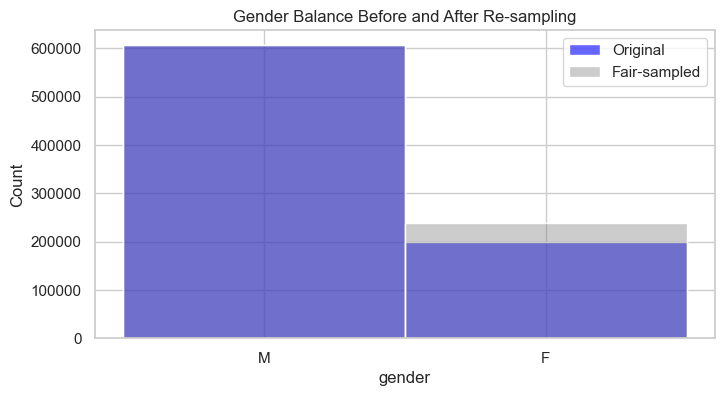

,user_id:token,item_id:token,timestamp:float,label:float,rating:float,gender
0,2761,1910,973146700.0,1.0,4.0,M
1,904,1343,980206300.0,0.0,2.0,M
2,5100,3844,967806100.0,1.0,4.0,M
3,3051,3107,970205200.0,1.0,3.0,M
4,955,648,975210240.0,1.0,3.0,F


In [8]:
# 7. Optional: plot before and after
plt.figure(figsize=(8,4))
sns.histplot(data=merged_df, x="gender", stat="count", color="blue", label="Original", alpha=0.6)
sns.histplot(data=df_fair, x="gender", stat="count", color="gray", label="Fair-sampled", alpha=0.4)
plt.title("Gender Balance Before and After Re-sampling")
plt.legend()
plt.show()

display(df_fair.head())


In [9]:
# 8. Save oversampled interaction set
import os

save_path = 'datasets/ml-1m/ml-1m.train.inter'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# 保存
df_fair[['user_id:token', 'item_id:token', 'timestamp:float', 'label:float']].to_csv(
    save_path,
    sep='\t',
    index=False
)
print(f"✅ Fair oversampled dataset saved to {save_path}")

✅ Fair oversampled dataset saved to datasets/ml-1m/ml-1m.train.inter


In [10]:
import shutil

src_path = '../datasets/split_datasets/ml-1m/ml-1m.valid.inter'
dst_dir = 'datasets/ml-1m'
dst_path = os.path.join(dst_dir, 'ml-1m.valid.inter')

os.makedirs(dst_dir, exist_ok=True)

# 复制文件
shutil.copyfile(src_path, dst_path)

print(f"✅ File copied to {dst_path}")

src_path = '../datasets/split_datasets/ml-1m/ml-1m.test.inter'
dst_path = os.path.join(dst_dir, 'ml-1m.test.inter')

# 复制文件
shutil.copyfile(src_path, dst_path)

print(f"✅ File copied to {dst_path}")

✅ File copied to datasets/ml-1m/ml-1m.valid.inter
✅ File copied to datasets/ml-1m/ml-1m.test.inter


In [11]:
from recbole.quick_start import run_recbole

run_recbole(config_file_list=['ml-1m-oversample.yaml'])

15 Jun 15:52    INFO  ['/Users/huangjiaqing/Desktop/Recommender Systems/RScode/.venv/lib/python3.10/site-packages/ipykernel_launcher.py', '-f', '/Users/huangjiaqing/Library/Jupyter/runtime/kernel-f9497ff5-131b-45fa-a155-94fbc932219e.json']
15 Jun 15:52    INFO  
General Hyper Parameters:
gpu_id = 0
use_gpu = True
seed = 42
state = INFO
reproducibility = True
data_path = datasets/ml-1m
checkpoint_dir = checkpoint_saved/ml-1m/
show_progress = False
save_dataset = True
dataset_save_path = None
save_dataloaders = True
dataloaders_save_path = None
log_wandb = True

Training Hyper Parameters:
epochs = 100
train_batch_size = 1024
learner = adam
learning_rate = 0.0005
train_neg_sample_args = {'distribution': 'uniform', 'sample_num': 1, 'alpha': 1.0, 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 10
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'split': {'RS': [0.8, 0.1, 0.1]}, 'order': 'RO', 'group_by': 'user', '

15 Jun 15:52    INFO  epoch 0 training [time: 4.27s, train loss: 543.6567]
15 Jun 15:52    INFO  epoch 0 evaluating [time: 1.69s, valid_score: 0.055600]
15 Jun 15:52    INFO  valid result: 
precision@10 : 0.0444    recall@10 : 0.0468    hit@10 : 0.344    map@10 : 0.0222    ndcg@10 : 0.0556    itemcoverage@10 : 0.0637    averagepopularity@10 : 2240.7319    shannonentropy@10 : 0.0109    giniindex@10 : 0.9969    tailpercentage@10 : 0.0025
15 Jun 15:52    INFO  Saving current: checkpoint_saved/ml-1m/BPR-Jun-15-2025_15-52-07.pth
15 Jun 15:52    INFO  epoch 1 training [time: 5.73s, train loss: 367.6488]
15 Jun 15:52    INFO  epoch 1 evaluating [time: 1.46s, valid_score: 0.057300]
15 Jun 15:52    INFO  valid result: 
precision@10 : 0.0448    recall@10 : 0.0473    hit@10 : 0.3526    map@10 : 0.0233    ndcg@10 : 0.0573    itemcoverage@10 : 0.0272    averagepopularity@10 : 2256.6765    shannonentropy@10 : 0.0239    giniindex@10 : 0.9972    tailpercentage@10 : 0.0006
15 Jun 15:52    INFO  Saving 

{'best_valid_score': 0.0771,
 'valid_score_bigger': True,
 'best_valid_result': OrderedDict([('precision@10', 0.0587),
              ('recall@10', 0.0716),
              ('hit@10', 0.4487),
              ('map@10', 0.0322),
              ('ndcg@10', 0.0771),
              ('itemcoverage@10', 0.3558),
              ('averagepopularity@10', 1368.194),
              ('shannonentropy@10', 0.0043),
              ('giniindex@10', 0.9322),
              ('tailpercentage@10', 0.0002)]),
 'test_result': OrderedDict([('precision@10', 0.0573),
              ('recall@10', 0.0694),
              ('hit@10', 0.4399),
              ('map@10', 0.0301),
              ('ndcg@10', 0.0735),
              ('itemcoverage@10', 0.3558),
              ('averagepopularity@10', 1368.194),
              ('shannonentropy@10', 0.0043),
              ('giniindex@10', 0.9322),
              ('tailpercentage@10', 0.0002)])}

In [12]:
from recbole.quick_start import load_data_and_model
from recbole.utils.case_study import full_sort_topk
from tqdm import tqdm
import pandas as pd
import numpy as np

# 1. 加载模型和数据
config, model, dataset, train_data, valid_data, test_data = load_data_and_model(
    model_file='checkpoint_saved/ml-1m/BPR-Jun-15-2025_15-52-07.pth'
)

# Step 1: Get all internal user IDs
all_uids = list(range(dataset.user_num))

# Step 2: Filter out users who have no interactions in the test set
valid_uids = [uid for uid in tqdm(all_uids) if test_data.uid2history_item[uid] is not None]

# Step 3: Convert to Series
uid_series = np.array(valid_uids)

# Step 4: Run full_sort_topk
topk_scores, topk_index = full_sort_topk(uid_series, model, test_data, k=10, device=config['device'])

# Step 5: Convert internal item IDs to external tokens
external_item_lists = [dataset.id2token(dataset.iid_field, row.cpu().tolist()) for row in topk_index]
external_user_list = [dataset.id2token(dataset.uid_field, [uid])[0] for uid in uid_series]
score_lists = [row.cpu().tolist() for row in topk_scores]

# load gender information
user_df = pd.read_csv('../datasets/atomic_datasets/ml-1m/ml-1m.user', sep='\t')
user_df['user_id:token'] = user_df['user_id:token'].astype(str)
user2gender = dict(zip(user_df['user_id:token'], user_df['gender:token']))

# Step 6: Save as DataFrame
df = pd.DataFrame({
    'user_id': external_user_list,
    'gender': [user2gender.get(uid, 'unknown') for uid in external_user_list],
    'topk_items': [','.join(items) for items in external_item_lists],
    'topk_scores': [','.join([f'{s:.4f}' for s in scores]) for scores in score_lists]
})
display(df.head())
print(df.nunique())
df.to_csv('../rank_results/ml-1m/ml_top10_oversample.csv', index=False)
print("save ml_top10_oversample successfully")

15 Jun 15:57    INFO  
General Hyper Parameters:
gpu_id = 0
use_gpu = True
seed = 42
state = INFO
reproducibility = True
data_path = datasets/ml-1m
checkpoint_dir = checkpoint_saved/ml-1m/
show_progress = False
save_dataset = True
dataset_save_path = None
save_dataloaders = True
dataloaders_save_path = None
log_wandb = True

Training Hyper Parameters:
epochs = 100
train_batch_size = 1024
learner = adam
learning_rate = 0.0005
train_neg_sample_args = {'distribution': 'uniform', 'sample_num': 1, 'alpha': 1.0, 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 10
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'split': {'RS': [0.8, 0.1, 0.1]}, 'order': 'RO', 'group_by': 'user', 'mode': {'valid': 'full', 'test': 'full'}}
repeatable = True
metrics = ['Precision', 'Recall', 'Hit', 'MAP', 'NDCG', 'ItemCoverage', 'AveragePopularity', 'ShannonEntropy', 'GiniIndex', 'TailPercentage']
topk = [10]
valid_metric = NDCG@10
val

,user_id,gender,topk_items,topk_scores
0,2761,M,"1304,1580,648,368,380,457,780,2948,10,2916","3.9351,3.8756,3.8653,3.8535,3.8250,3.7791,3.77..."
1,904,M,"70,1222,1407,1258,2118,1321,1994,1974,3476,2288","4.5103,4.5013,4.4497,4.4428,4.3979,4.3513,4.32..."
2,5100,M,"919,1225,924,1097,34,1230,912,2971,3545,3363","2.7609,2.7362,2.7129,2.6802,2.6522,2.5457,2.54..."
3,3051,M,"3793,2571,2628,70,2858,3578,480,1580,110,589","4.2358,4.1503,4.0631,4.0519,4.0351,4.0075,3.98..."
4,955,F,"457,3418,2916,377,1610,2571,1617,32,1573,1094","3.4299,3.3338,3.3328,3.2436,3.2112,3.1892,3.13..."


user_id        6040
gender            2
topk_items     6040
topk_scores    6040
dtype: int64
save ml_top10_oversample successfully
